## This notebook produces the input files for the MOM6

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size':16})
rc('text', usetex=True)
rc('xtick', labelsize=16) 
rc('ytick', labelsize=16) 
rc('axes', titlesize=22)    # fontsize of the axes title
rc('axes', labelsize=18)    # fontsize of the x and y labels

import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import os

Define basic model configuration parameters.

In [3]:
# Configuration parameters
# (prescribed by user)

nlayers = 2    #number of layers

# domain size
Lx = 3200      # domain zonal extent [km]
Ly = 1600      # domain meridional extent [km]
H  = 4000  # total fluid's depth in [m] 

# bathymetric details
h0 = 400   # ridge height in [m]
sigh = 70  # gaussian ridge half-width [km]

gridspacing = 4  # in [km]

# wind stress forcing
tau0 = 0.1 # peak wind stress value [N/m^2]

In [4]:
ninterf = nlayers + 1    #number of interfaces
interfaces = np.arange(0,  ninterf)


nx = round(Lx/gridspacing)
ny = round(Ly/gridspacing)

if nlayers==1:
    layerdensities = [1027.810]  # [kg/m^3]
    restintefaceheights = [0.0]  # [m]
elif nlayers==2:
    layerdensities = [1027.326, 1027.957] # [kg/m^3]
    restintefaceheights = [0.0, -934.0]   # [m]
elif nlayers==3:
    layerdensities = [1027.18, 1027.65, 1028.00 ]  # [kg/m^3]
    restintefaceheights = [0.0, -544.73, -1432.95] # [m]
elif nlayers==4:
    layerdensities = [1027.10, 1027.48, 1027.79, 1028.02]   # [kg/m^3]
    restintefaceheights = [0.0, -385.65, -915.37, -1763.96] # [m]
else:
    print("only nlayers=1,2,3,4 are allowed")

Create folder to save the input files.

In [5]:
outfolder = 'layer'+str(nlayers)+'/layer'+str(nlayers)+'_tau'+(str("{:.1e}".format(tau0))).replace('.', 'p')

if not os.path.exists(outfolder):
    os.makedirs(outfolder)
    
print("Input files will be saved in folder: "+outfolder)

Input files will be saved in folder: layer2/layer2_tau1p0e-01


Construct the grid, the bathymetry, the rest-fluid interfaces depths, and the wind stress profile.

In [6]:
# the x, y grid
x = np.arange(0, Lx, gridspacing)
y = np.arange(-Ly/2, Ly/2, gridspacing)

X, Y = np.meshgrid(x, y)


# bathymetry
def oneridge(x0):
    return h0*np.exp(-((X-x0)**2/(2*sigh**2)))

# the locations of the Gaussian ridges
ridgespos = np.arange(400, Lx, 600)

hbottom = np.zeros((ny, nx))
for j in np.arange(0, len(ridgespos)):
    hbottom = hbottom + oneridge(ridgespos[j])


# the rest fluid interfaces depths
eta = np.empty([ninterf, ny, nx])
for j in np.arange(0, nlayers):
    eta[j, :, :] =  restintefaceheights[j]

eta[nlayers] = -H + hbottom


# wind stress

STRESS_X = np.zeros([ny, nx])
STRESS_Y = np.zeros([ny, nx])

# this produces an assymetric wind profile that is centred at distance 3*Ly/8 from the southern wall
STRESS_X = tau0*np.sin(np.pi*(Y+Ly/2)/(3*Ly/4))**2
STRESS_X[Y+Ly/2>=3*Ly/4] = 0

Plot the bathymetry and wind stress profile

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


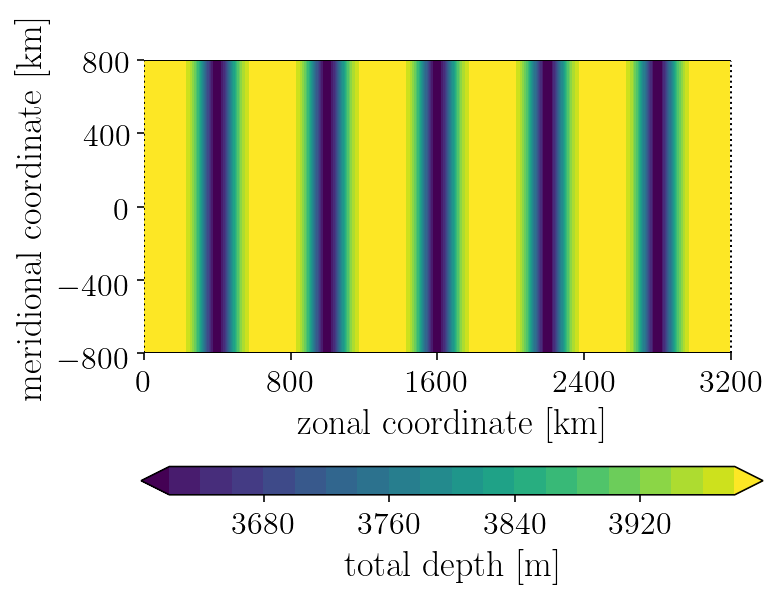

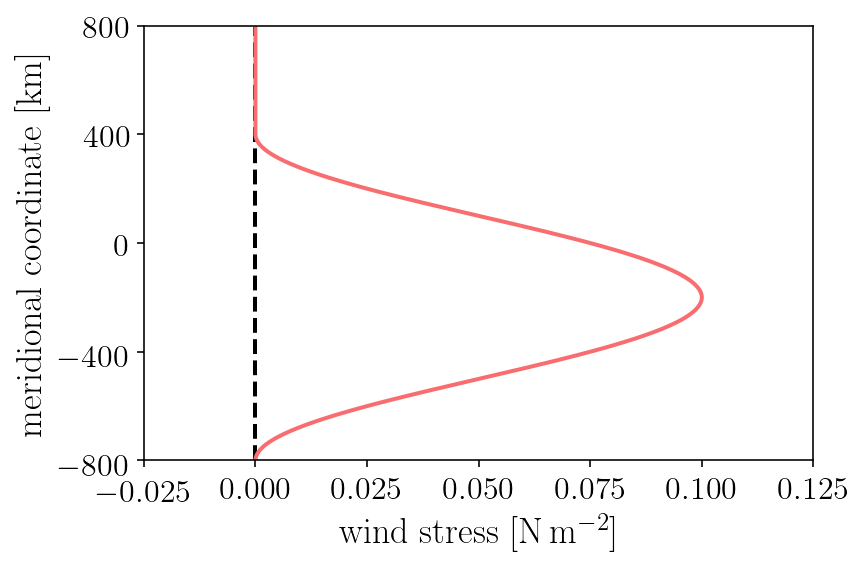

In [7]:
plt.figure()
ax = plt.axes()
ax.set_aspect(1)
plt.xlabel('zonal coordinate [km]')
plt.ylabel('meridional coordinate [km]')
plt.contourf(x, y, -eta[nlayers], 20, extend='both', vmin = H-h0, vmax=H)
plt.xticks(np.linspace(0, Lx, 5))
plt.yticks(np.linspace(-Ly/2, Ly/2, 5))
plt.clim(H-h0, H)
c = plt.colorbar(orientation='horizontal', spacing='proportional', fraction=0.065, pad=0.26, ticks=np.linspace(H-h0, H, 6))
c.set_label('total depth [m]')
plt.box(False)
plt.plot(x, 0*x-Ly/2, 'k', linewidth=1)
plt.plot(x, 0*x+Ly/2, 'k', linewidth=1)
plt.plot(0*y, y, ':k', linewidth=1)
plt.plot(0*y+Lx, y, ':k', linewidth=1)
plt.ylim(-Ly/2, Ly/2)
plt.savefig(outfolder+'/domain.pdf', bbox_inches='tight')

plt.figure()
plt.plot(0*STRESS_X[:,0], y,'--k', label='0.0', lw=2)
plt.plot(1*STRESS_X[:,0], y,'#F86D70', label='0.05', lw=2)
plt.yticks(np.linspace(-Ly/2, Ly/2, 5))
plt.xticks(np.linspace(-0.25*tau0, 1.25*tau0, 7))
plt.xlim(-0.25*tau0, 1.25*tau0)
plt.ylim(-Ly/2, Ly/2)
plt.xlabel('wind stress [N$\,$m$^{-2}$]')
plt.ylabel('meridional coordinate [km]')
plt.savefig(outfolder+'/windstress.pdf', bbox_inches='tight')


Save the input fields as netCDF files to be called by MOM6.

In [8]:
driverfilename = outfolder+'/driver-layers-topo-densities.nc'
ncOutput = Dataset(driverfilename, 'w', format='NETCDF4')
ncOutput.createDimension('x', nx)
ncOutput.createDimension('y', ny)
ncOutput.createDimension('Layer', nlayers)
ncOutput.createDimension('interface', ninterf)

ncX = ncOutput.createVariable('x', 'float', ('x',))
ncX[:] = x

ncY = ncOutput.createVariable('y', 'float', ('y',))
ncY[:] = y

ncL = ncOutput.createVariable('Layer', 'float', ('Layer',))
ncL[:] = layerdensities

ncEta = ncOutput.createVariable('eta', 'float', ('interface', 'y', 'x'))
ncEta[:] = eta

ncTopo = ncOutput.createVariable('topo', 'float', ('y', 'x'))
ncTopo[:] = -eta[-1]

ncOutput.close()

windfilename = outfolder+'/windstress.nc'
ncOutput = Dataset(windfilename, 'w',format="NETCDF4")

ncOutput.createDimension('x', nx)
ncOutput.createDimension('y', ny)

ncX = ncOutput.createVariable('x', 'float', ('x', ))
ncX[:] = x

ncY = ncOutput.createVariable('y', 'float', ('y', ))
ncY[:] = y

ncSX = ncOutput.createVariable('STRESS_X', 'float', ('y','x'))
ncSX[:] = STRESS_X

ncSY = ncOutput.createVariable('STRESS_Y', 'float', ('y', 'x'))
ncSY[:] = STRESS_Y

ncOutput.close()